# Non-Hermitian Persistent Current Transport
## Normal Rings
Authors: Pei-Xin Shen, Zhide Lu, Jose L. Lado, and Mircea Trif

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dmrgpy import fermionchain
from scipy.interpolate import interp1d

In [2]:
t = -1  # hopping strength
g = -1  # chemical potential of the ring
g_lead = 0  # chemical potential of the reservoir
kappa = 1*t  # reservoir coupling strength
N_ring = 6
N_reservoir = 101
N_total = N_ring + N_reservoir

fc = fermionchain.Fermionic_Chain(N_total) # create the fermionic chain
# set random hopping strength of the ring and uniform hopping strength
t_site = np.append(np.array([-0.859915, -0.884918, -0.918446, -0.846311, -1.19937, -0.984676]), np.full(N_reservoir, t))
# t_site = np.full(N_total, t)
# set chemical potential
g_site = np.append(np.full(N_ring, g), np.full(N_reservoir, g_lead))


def model_Hamiltonian(phi, delta=0):
    h = 0  # initialize Hamiltonian
    for i in range(N_ring):
        # create hopping terms of the ring
        h = h + t_site[i]*np.exp(-1j*phi/N_ring)*fc.Cdag[i]*fc.C[np.mod(i+1, N_ring)]
    if N_reservoir >0:
        for i in range(N_ring, N_total-1):
            # create hopping terms of the reservoir
            h = h + t_site[i]*fc.Cdag[i]*fc.C[i+1]
        # couple the ring and the reservoir
        h = h + kappa*fc.Cdag[N_ring-1]*fc.C[N_ring]
    # make the Hamiltonian Hermitian
    h = h + h.get_dagger()
    for i in range(N_ring):
        # create NN-type many-body interactions
        # h = h + delta*fc.N[i]*fc.N[np.mod(i+1, N_ring)]
        # create ZZ-type many-body interactions
        # h = h + delta*(1/4 - fc.Cdag[i]*fc.C[i]/2 - fc.Cdag[np.mod(i+1, N_ring)]*fc.C[np.mod(i+1, N_ring)]/2 + fc.Cdag[i]*fc.C[i]*fc.Cdag[np.mod(i+1, N_ring)]*fc.C[np.mod(i+1, N_ring)])
        h = h + delta*(fc.N[i] - 1/2)*(fc.N[np.mod(i+1, N_ring)] - 1/2)
        # on-site chemical potential
        h = h + g_site[i]*fc.Cdag[i]*fc.C[i]
    if N_reservoir >0:
        for i in range(N_ring, N_total):
            # create the on-site chemical potential of the reservoir
            h = h + g_site[i]*fc.Cdag[i]*fc.C[i]
    return h
def energy_current(phi, delta=0, mode="DMRG", i=N_ring-1):
    h = model_Hamiltonian(phi, delta)
    fc.set_hamiltonian(h)
    return np.array([fc.gs_energy(mode), t_site[i]*((-1j)*fc.vev(np.exp(-1j*phi/N_ring)*fc.Cdag[i]*fc.C[np.mod(i+1, N_ring)]-np.exp(+1j*phi/N_ring)*fc.Cdag[np.mod(i+1, N_ring)]*fc.C[i], mode)).real])

In [3]:
phi_int = np.pi
phi_min = np.pi - phi_int
phi_max = np.pi + phi_int
phi_num = 11
phi_list = np.linspace(phi_min, phi_max, phi_num)
print(phi_list)

[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 6.28318531]


In [4]:
delta = 0
[eigen_values_free, current_values_free] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_free)
print(current_values_free)

[-71.25846977 -71.28857872 -71.35650471 -71.4199148  -71.46135661
 -71.47559268 -71.46135665 -71.4199148  -71.3565047  -71.28857872
 -71.25846968]
[-0.00000000e+00 -9.09290018e-02 -1.12228210e-01 -8.56810871e-02
 -4.50146142e-02  3.04503326e-09  4.50145961e-02  8.56810974e-02
  1.12228252e-01  9.09290250e-02  6.34427440e-15]


In [5]:
delta = 1
[eigen_values_weak, current_values_weak] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_weak)
print(current_values_weak)

[-71.72623035 -71.72030227 -71.72757625 -71.77083235 -71.80755394
 -71.82076912 -71.80755394 -71.77083235 -71.72757629 -71.72030227
 -71.72623035]
[-0.00000000e+00  1.29157181e-02 -4.94558645e-02 -7.20011793e-02
 -4.14200574e-02  1.51862081e-09  4.14200588e-02  7.20011682e-02
  4.94562873e-02 -1.29157128e-02 -2.26628752e-14]


In [11]:
delta = 8
[eigen_values_strong, current_values_strong] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_strong)
print(current_values_strong)

[-79.79322213 -79.78715019 -79.76949713 -79.74196589 -79.70788415
 -79.6822048  -79.70787476 -79.74195057 -79.7694935  -79.78715136
 -79.79321682]
[-0.00000000e+00  1.91759581e-02  3.65888567e-02  5.02704976e-02
  5.60861651e-02  4.10020006e-08 -5.60932769e-02 -5.02747550e-02
 -3.65893022e-02 -1.91759025e-02  1.13705282e-09]


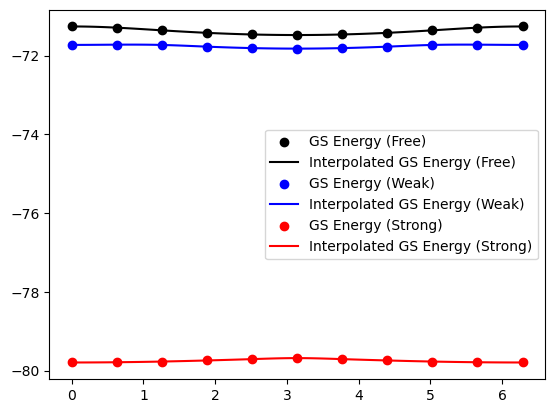

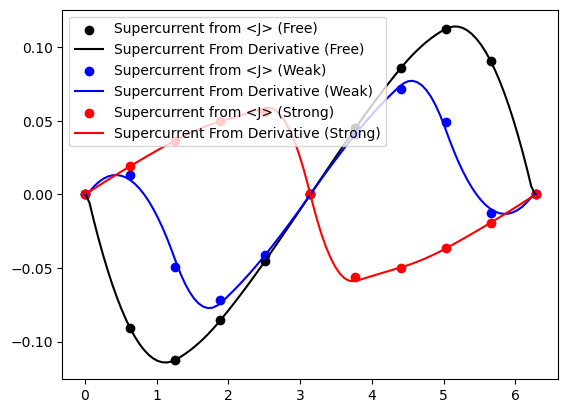

In [12]:
# Create an interpolating function (cubic spline)
interp_GS_free = interp1d(phi_list, eigen_values_free, kind='cubic')
interp_GS_weak = interp1d(phi_list, eigen_values_weak, kind='cubic')
interp_GS_strong = interp1d(phi_list, eigen_values_strong, kind='cubic')

# Generate data points for interpolation and derivative calculation
phi_interp = np.linspace(phi_list.min(), phi_list.max(), 100)
GS_free_interp = interp_GS_free(phi_interp)
GS_weak_interp = interp_GS_weak(phi_interp)
GS_strong_interp = interp_GS_strong(phi_interp)

# Calculate the derivative using NumPy's gradient function
GS_free_derivative = np.gradient(GS_free_interp, phi_interp)
GS_weak_derivative = np.gradient(GS_weak_interp, phi_interp)
GS_strong_derivative = np.gradient(GS_strong_interp, phi_interp)

# Plot the original data, interpolated function, and the derivative

plt.scatter(phi_list, eigen_values_free, label='GS Energy (Free)', color='black')
plt.plot(phi_interp, GS_free_interp, label='Interpolated GS Energy (Free)', color='black')
plt.scatter(phi_list, eigen_values_weak, label='GS Energy (Weak)', color='blue')
plt.plot(phi_interp, GS_weak_interp, label='Interpolated GS Energy (Weak)', color='blue')
plt.scatter(phi_list, eigen_values_strong, label='GS Energy (Strong)', color='red')
plt.plot(phi_interp, GS_strong_interp, label='Interpolated GS Energy (Strong)', color='red')
plt.legend()
plt.show()

plt.scatter(phi_list, current_values_free, label='Supercurrent from <J> (Free)', color='black')
plt.plot(phi_interp, GS_free_derivative, label='Supercurrent From Derivative (Free)', color='black')
plt.scatter(phi_list, current_values_weak, label='Supercurrent from <J> (Weak)', color='blue')
plt.plot(phi_interp, GS_weak_derivative, label='Supercurrent From Derivative (Weak)', color='blue')
plt.scatter(phi_list, current_values_strong, label='Supercurrent from <J> (Strong)', color='red')
plt.plot(phi_interp, GS_strong_derivative, label='Supercurrent From Derivative (Strong)', color='red')
plt.legend()
plt.show()

In [8]:
import csv
with open('freeRing.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_free, current_values_free])
with open('weakRing.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_weak, current_values_weak])
with open('strongRing.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_strong, current_values_strong])
